## Multi-label prediction with Planet Amazon dataset

In [0]:
      ############# IMPORTANT ##########

# One important feature of the Planet dataset is that it is a multi-label dataset. 
# That is: each satellite image can contain multiple labels, whereas previous datasets 
# we've looked at had exactly one label per image.

In [0]:
from fastai.vision import *

In [0]:
#!pip install kaggle --upgrade

In [2]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
# ! mkdir -p ~/.kaggle/
# ! mv kaggle.json ~/.kaggle/

In [0]:
# path = Config.data_path()/'planet'
# path.mkdir(parents=True, exist_ok=True)
# path

PosixPath('/root/.fastai/data/planet')

In [0]:
# !chmod 600 /root/.kaggle/kaggle.json

In [0]:
! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train-jpg.tar.7z

#! kaggle competitions download -c planet-understanding-the-amazon-from-space -f train_v2.csv -p {path}  

#!kaggle competitions download -c planet-understanding-the-amazon-from-space
#! unzip -q -n {path}/train_v2.csv.zip -d {path}

In [3]:
!sudo apt install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-430
Use 'sudo apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 7 not upgraded.


In [0]:
# ! 7za -bd -y -so x {path}/train-jpg.tar.7z | tar xf - -C {path.as_posix()}

In [0]:
#! 7za -bd -y -so x path/train-jpg.tar.7z | tar xf - -C path.as_posix()

/bin/bash: -c: line 0: syntax error near unexpected token `('
/bin/bash: -c: line 0: ` 7za -bd -y -so x path/train-jpg.tar.7z | tar xf - -C path.as_posix()'


In [0]:
      #### Locally Uploading File in Gdrive ####

#!apt-get install p7zip-full
!p7zip -d "/content/gdrive/My Drive/FastAI/train-jpg.tar.7z"
!tar -xvf "/content/train-jpg.tar"

In [15]:
!ls

gdrive	sample_data  train-jpg	train-jpg.tar  train_v2.csv


In [0]:
#! unzip -q -n "/content/gdrive/My Drive/FastAI/train_v2.csv.zip"

In [7]:
df = pd.read_csv('/content/gdrive/My Drive/FastAI/train_v2.csv')
df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [0]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [0]:
# NOTE : Upload the train_v2.csv file here on the left side panel

In [0]:
path = '/content/'

In [0]:
np.random.seed(42)

src = (ImageList.from_csv(path,'train_v2.csv', folder = 'train-jpg', suffix = '.jpg')
      .split_by_rand_pct(0.2).label_from_df(label_delim=' '))
# Creates 2 seperate Dataset, Training and validation


In [0]:
## NOTE : View the video at 25:15 for detailed info on diff types of DataLoaders

In [0]:
data = (src.transform(tfms,size=128).databunch().normalize(imagenet_stats)) # This Creates the 
# DataLoader and DataBunch in one go

In [0]:
doc(ImageDataBunch)

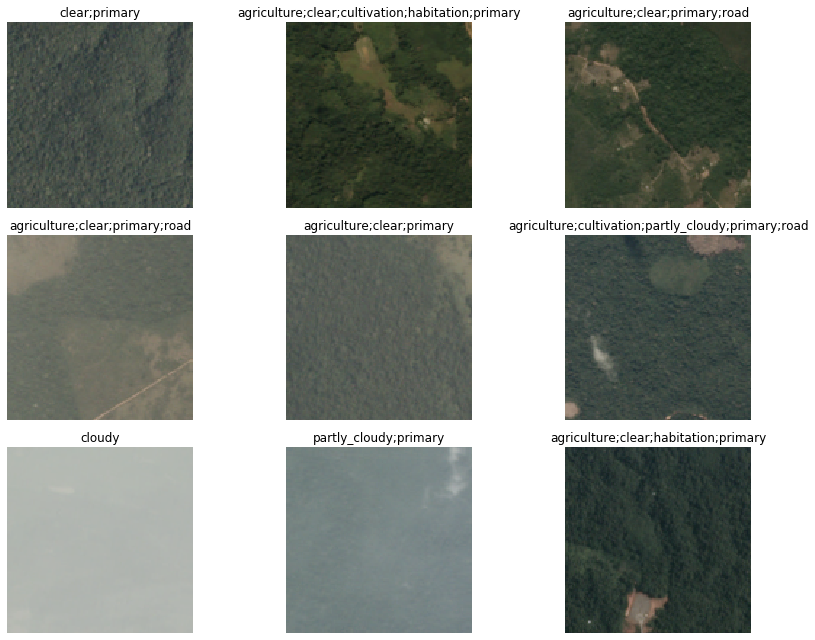

In [0]:
data.show_batch(rows=3, figsize=(12,9))

In [0]:
arch = models.resnet50

In [13]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta,thresh=0.2)
learn = cnn_learner(data,arch,metrics = [acc_02,f_score]) # create_cnn is deprecated now

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 61.3MB/s]


In [26]:
data.c

17

In [27]:
data.classes

['agriculture',
 'artisinal_mine',
 'bare_ground',
 'blooming',
 'blow_down',
 'clear',
 'cloudy',
 'conventional_mine',
 'cultivation',
 'habitation',
 'haze',
 'partly_cloudy',
 'primary',
 'road',
 'selective_logging',
 'slash_burn',
 'water']

In [14]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


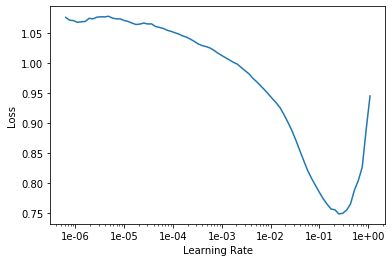

In [15]:
learn.recorder.plot()

In [0]:
lr = 0.01

In [17]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.140459,0.117716,0.946699,0.897021,02:45
1,0.117006,0.100623,0.947295,0.910557,02:47
2,0.103848,0.092782,0.952963,0.920045,02:47
3,0.095925,0.087994,0.955020,0.923484,02:47
4,0.092927,0.087306,0.956102,0.924660,02:47


In [0]:
 learn.save('stage-1-rn50')

In [0]:
# NOW : Fine Tune the whole model

In [0]:
learn.unfreeze()

In [20]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


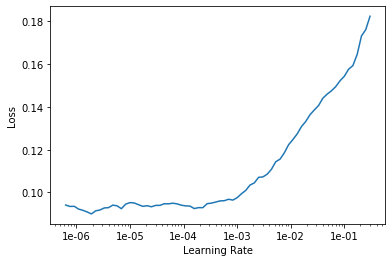

In [21]:
learn.recorder.plot() 

In [22]:
learn.fit_one_cycle(5,slice(1e-5,lr/5)) 

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.100226,0.093112,0.954765,0.917616,02:52
1,0.096862,0.089870,0.956523,0.923050,02:53
2,0.092067,0.086642,0.956618,0.925755,02:52
3,0.083865,0.083650,0.957904,0.927127,02:55
4,0.081071,0.082810,0.959481,0.929315,02:53


In [0]:
learn.save('stage-2-rn50')      

# Transfer Learning..
## We have trained our model for 128 * 128 images, now applying the same trained model to 256 * 256 images

In [0]:
data = (src.transform(tfms,size = 256).databunch().normalize(imagenet_stats))

In [0]:
learn.data = data

In [27]:
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [0]:
learn.freeze()

In [29]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


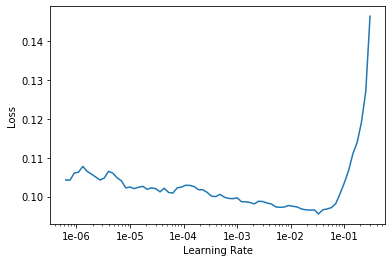

In [30]:
learn.recorder.plot()

In [0]:
lr=1e-2/2

In [32]:
learn.fit_one_cycle(5,slice(lr))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.089983,0.085380,0.957846,0.925581,04:59
1,0.088469,0.082877,0.958929,0.929489,04:54
2,0.087616,0.082213,0.957040,0.929937,04:54
3,0.081580,0.081510,0.958006,0.928419,04:53
4,0.081649,0.081216,0.960745,0.931712,04:53


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

In [35]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.085039,0.084044,0.957526,0.928799,05:10
1,0.089292,0.083638,0.956524,0.925908,05:12
2,0.084003,0.081723,0.958304,0.930030,05:13
3,0.075378,0.081208,0.961044,0.930710,05:11
4,0.074742,0.080510,0.960011,0.932250,05:12


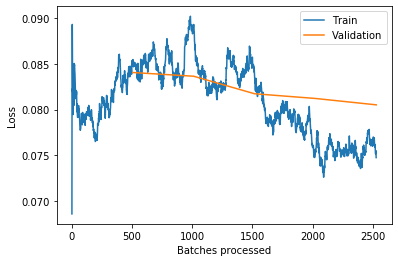

In [36]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')